# Example of usage Spark OCR for Text Detections

This notebook demonstrate pipeline for detect text in image.

## Install spark-ocr python packge
Need to specify:
- secret
- license
- aws credentials

In [1]:
secret = ""
license = ""
AWS_ACCESS_KEY_ID = ""
AWS_SECRET_ACCESS_KEY = ""

version = secret.split("-")[0]
spark_ocr_jar_path = "../../../target/scala-2.11/"

In [ ]:
# install from local package 
#%pip install ../../python/dist/spark-ocr-3.10.0+spark30.tar.gz

In [4]:
# install from PYPI using secret
#%pip install spark-ocr==$version+spark30 --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade
#%pip install --ignore-installed spark-nlp==3.3.4

In [2]:
import os
import sys

if AWS_ACCESS_KEY_ID != "":
    os.environ["AWS_ACCESS_KEY_ID"] = AWS_ACCESS_KEY_ID
    os.environ["AWS_SECRET_ACCESS_KEY"] = AWS_SECRET_ACCESS_KEY
    
if license:
    os.environ['JSL_OCR_LICENSE'] = license

## Initialization of spark session
Need specify path to `spark-ocr-assembly.jar` or `secret`

In [3]:
from pyspark import SparkConf
from sparkocr import start

spark = start(secret=secret, jar_path = spark_ocr_jar_path, nlp_version="3.3.4")

spark

Spark version: 3.0.2
Spark NLP version: 3.3.4
Spark OCR version: 3.10.0



## Read imageand display it

In [ ]:
import pkg_resources
from pyspark.ml import PipelineModel
import pyspark.sql.functions as f
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_images


imagePath = pkg_resources.resource_filename('sparkocr', 'resources/ocr/text_detection/020_Yas_patella.jpg')
image_df = spark.read.format("binaryFile").load(imagePath)

display_images(BinaryToImage().setImageType(ImageType.TYPE_3BYTE_BGR).transform(image_df), "image")

## Define OCR Pipeline for detect text and draw bounding boxes on original image

In [7]:
binary_to_image = BinaryToImage() 
binary_to_image.setImageType(ImageType.TYPE_3BYTE_BGR)

text_detector = ImageTextDetector.pretrained("text_detection_v1", "en", "clinical/ocr")
text_detector.setInputCol("image")
text_detector.setOutputCol("text_regions")
text_detector.setSizeThreshold(10)
text_detector.setScoreThreshold(0.9)
text_detector.setLinkThreshold(0.4)
text_detector.setTextThreshold(0.2)
text_detector.setWidth(1512)
text_detector.setHeight(2016)

draw_regions = ImageDrawRegions()
draw_regions.setInputCol("image")
draw_regions.setInputRegionsCol("text_regions")
draw_regions.setOutputCol("image_with_regions")
draw_regions.setRectColor(Color.green)
draw_regions.setRotated(True)

pipeline = PipelineModel(stages=[
    binary_to_image,
    text_detector,
    draw_regions
])

text_detection_v1 download started this may take some time.
Approximate size to download 73.5 MB


## Run pipeline and show results


    Image #0:
    Origin: file:/Users/nmelnik/IdeaProjects/spark-ocr/python/sparkocr/resources/ocr/text_detection/020_Yas_patella1.jpg
    Resolution: 0 dpi
    Width: 1512 px
    Height: 2016 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


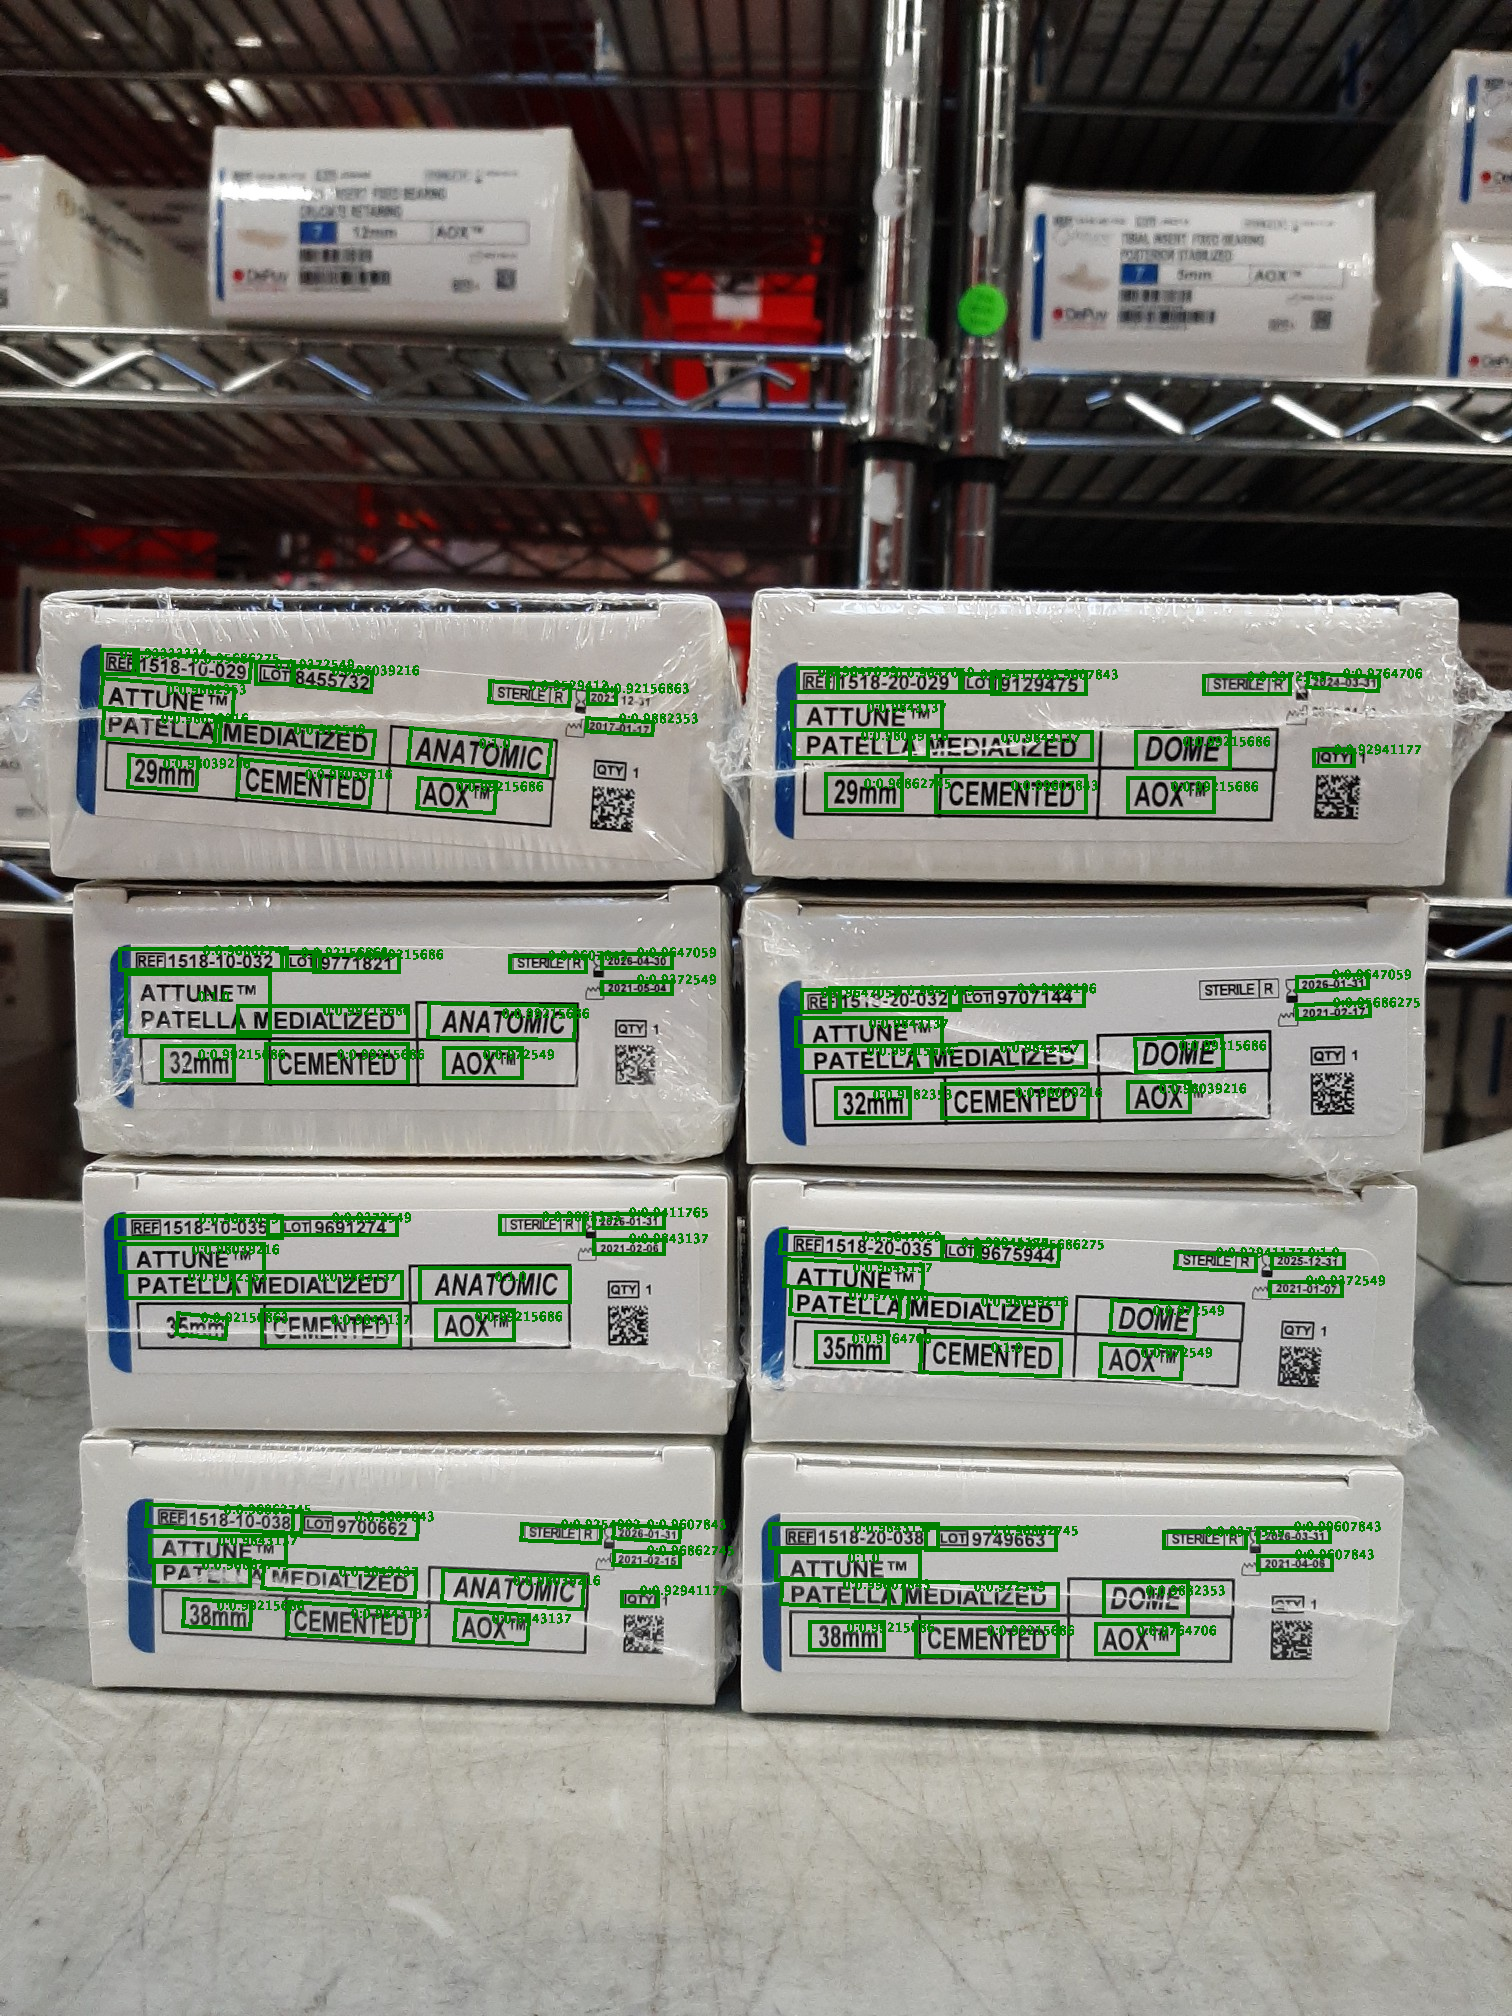

In [8]:
result =  pipeline.transform(image_df).cache()
display_images(result, "image_with_regions")

## Show regions with text

In [9]:
result.select(f.explode("text_regions")).show(10, False)

+--------------------------------------------------------------------------+
|col                                                                       |
+--------------------------------------------------------------------------+
|[0, 0, 120.0, 662.0, 24.0, 36.0, 0.93333334, 0, -90.0]                    |
|[0, 0, 192.90863, 667.2792, 22.30457, 117.72589, 0.95686275, 0, -85.91438]|
|[0, 0, 275.0, 673.0, 22.0, 38.0, 0.9372549, 0, -90.0]                     |
|[0, 0, 332.14755, 679.3771, 20.491804, 80.81968, 0.98039216, 0, -84.80557]|
|[0, 0, 818.0, 680.0, 24.0, 40.0, 0.9647059, 0, -90.0]                     |
|[0, 0, 895.0, 681.0, 22.0, 134.0, 0.9647059, 0, -90.0]                    |
|[0, 0, 980.0, 683.0, 18.0, 40.0, 0.9411765, 0, -90.0]                     |
|[0, 0, 1039.0, 683.0, 22.0, 94.0, 0.9607843, 0, -90.0]                    |
|[0, 0, 1343.9846, 682.27686, 14.750769, 71.97539, 0.9764706, 0, -86.82017]|
|[0, 0, 1247.0, 685.0, 18.0, 86.0, 0.9372549, 0, -90.0]                    |

In [16]:
result.select(f.explode("text_regions")).printSchema()

root
 |-- col: struct (nullable = true)
 |    |-- index: integer (nullable = false)
 |    |-- page: integer (nullable = false)
 |    |-- x: float (nullable = false)
 |    |-- y: float (nullable = false)
 |    |-- width: float (nullable = false)
 |    |-- height: float (nullable = false)
 |    |-- score: float (nullable = false)
 |    |-- label: string (nullable = false)
 |    |-- angle: float (nullable = false)



## Define pipeline for ecognize text and extract entyties

In [10]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.common import *


splitter = ImageSplitRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("text_regions") \
    .setOutputCol("text_image") \
    .setDropCols(["image"]) \
    .setExplodeCols(["text_regions"]) \
    .setRotated(True) \
    .setImageType(ImageType.TYPE_BYTE_GRAY)

ocr = ImageToText() \
    .setInputCol("text_image") \
    .setOutputCol("text") \
    .setPageSegMode(PageSegmentationMode.SINGLE_WORD) \
    .setIgnoreResolution(False)

documentAssembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

entityRuler = EntityRulerApproach() \
    .setInputCols(["document", "token"]) \
    .setOutputCol("entities") \
    .setPatternsResource(
      "patterns.json",
      ReadAs.TEXT,
      {"format": "jsonl"}
    ) \
    .setEnablePatternRegex(True)

pipeline_nlp = Pipeline().setStages([
    splitter,
    ocr,
    documentAssembler,
    tokenizer,
    entityRuler
])

text_result = pipeline_nlp.fit(result).transform(result).cache()

## Patterns for extract entyties

In [11]:
%%sh
cat patterns.json

{"id": "ref", "label": "REF", "patterns": ["\\d{4}-\\d{2}-\\d{3}"]}
{"id": "date", "label": "DATE", "patterns": ["\\d{4}-\\d{2}-\\d{2}"]}
{"id": "lot", "label": "LOT", "patterns": ["\\d{7}"]}

## Show recognized text

In [12]:
print(("").join([x.text for x in text_result.select("text").collect()]))

REF
1518-16-029
(on
8455732
REA
11518-20-029 .
[LOT]
19129475
2024-03)
| STERILE | R |
ATTUNE™
(STERILE | R |
202*
| ATTUNE™
PATELLA
2017-01-17.
MEDIALIZED
| PATELLA |
ANATOMIC
\ MEM A! IZED
DOME
QTY}
29mm
CEMENTED
29mm
| CEMENTED
AQX™
AOX™
® IREFI1518-10-032 |
19771821.
} 2026-04-30
| STERILE | R-
2026-01-31
|} 2021-05-04
(01719707144 —
145i 2-20-032
(REA
| 2021-02-17
ANATOMIC
\ MEDIALIZED
| ATTUNE™)
DOME
| CEMENTED.
. MEDIALIZEC
32mm
| PATELLA |
AOX™
AOX:
| CEMENTED
32mm
} 2026-01-31
| STERILE | R |
® IREF}1518-10-035 |
(L011 9691274 ©
| REFI1518-20-035 |
| 2021-02-06
{LoT]
9675944
| STERILE | R |
| 2025-12-31
-ATTUNE™
ANATOMIC |
| PATELLA |
\ MEDIALIZED >
| 2021-01-07
PATELLA
MEDIALIZED
DOME
ICEMENTEN |
amen
35mm
| CEMENTED
AOX™
| REFI1518-10-038 |
(66719700662
| STERILE | R |
(2026-01-31
® REFI1518-20-038 |
) 2026-03-31
(00719749663 >
| STERILE |R)
| ATTUNE™
2021-02-15
| ATTUNE™
} 2021-04-06
PATE:
MEDIALIZED -
ANATOMIC |
PATELLA |
\ MEDIALIZED —
DOME
lary)
38mm
CEMENTED
AOX™
38mm
|

## Display detected entyties

In [13]:
text_result.selectExpr("explode(entities)").show(truncate=False)

+-------------------------------------------------------------------------------+
|col                                                                            |
+-------------------------------------------------------------------------------+
|[chunk, 0, 10, 1518-16-029, [entity -> REF, id -> ref, sentence -> 0], []]     |
|[chunk, 0, 6, 8455732, [entity -> LOT, id -> lot, sentence -> 0], []]          |
|[chunk, 0, 11, 11518-20-029, [entity -> REF, id -> ref, sentence -> 0], []]    |
|[chunk, 0, 7, 19129475, [entity -> LOT, id -> lot, sentence -> 0], []]         |
|[chunk, 0, 9, 2017-01-17, [entity -> DATE, id -> date, sentence -> 0], []]     |
|[chunk, 2, 17, IREFI1518-10-032, [entity -> REF, id -> ref, sentence -> 0], []]|
|[chunk, 0, 7, 19771821, [entity -> LOT, id -> lot, sentence -> 0], []]         |
|[chunk, 2, 11, 2026-04-30, [entity -> DATE, id -> date, sentence -> 0], []]    |
|[chunk, 0, 9, 2026-01-31, [entity -> DATE, id -> date, sentence -> 0], []]     |
|[chunk, 3, 12, 